In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches
from typing import List, Optional, Tuple

import torch
import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import (Callback, LightningDataModule, LightningModule,
                               Trainer)
from pytorch_lightning.loggers import TensorBoardLogger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils

log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

from src.models.simclr import SimCLR

import SimpleITK as sitk

In [2]:
sitk.ProcessObject_SetGlobalWarningDisplay(False)


In [3]:
cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/logs_sst/bvisa-monai-BasicUnet-2x-segmentDice+contrastive/runs/2023-04-20_16-51-06/.hydra/config.yaml')
# cfg = OmegaConf.load('/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-full-res-corrected-skullstripHALF1000Epochs-unet-allAugm2/runs/2023-03-31_14-39-48/.hydra/config.yaml')

datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

# model: LightningModule = hydra.utils.instantiate(cfg.model,
#                                                  freeze_encoder=False)

print(cfg.data)

2023-04-20 16:57:11,204 - Len of train examples 38 len of validation examples 12
{'_target_': 'src.data.self_supervised_segm.ContrastiveDataModule', 'dataset_cfg': {'dataset': 'brainvisa', 'nviews': 2, 'target': 'GM', 'skull_strip': None, 'resample': None, 'use_2x2x2_preproc': True}, 'train_batch_size': 3, 'validation_batch_size': 3, 'num_workers': 10}


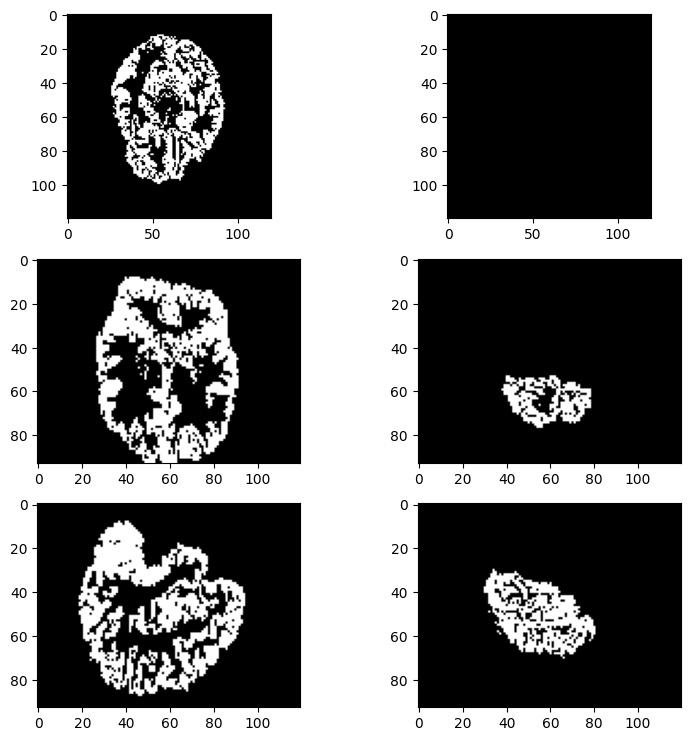

In [6]:
img, target = datamodule.train_dataset[0]
# plot images from batches
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
slc = 60


ax[0, 0].imshow(img[0][0, slc, :, :], cmap='gray')
ax[0, 1].imshow(img[1][0, slc+50, :, :], cmap='gray')
ax[1, 0].imshow(img[0][0, :, slc, :], cmap='gray')
ax[1, 1].imshow(img[1][0, :, slc+50, :], cmap='gray')
ax[2, 0].imshow(img[0][0, :, :, slc,], cmap='gray')
ax[2, 1].imshow(img[1][0, :, :, slc+50,], cmap='gray')
# ax[1].imshow(target[0, slc, :, :], alpha=0.5)    
plt.show()

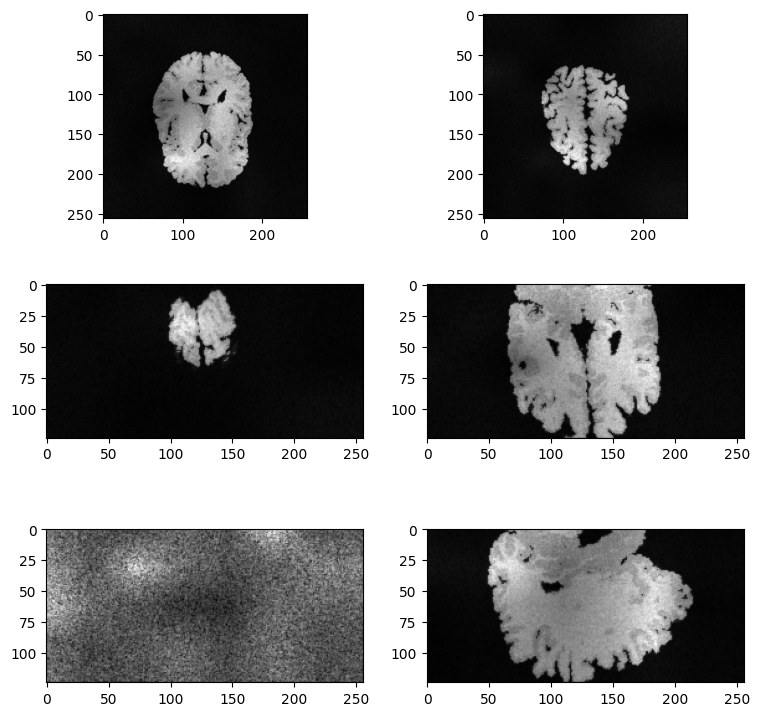

In [6]:
for batch in datamodule.train_dataloader():
    # plot images from batches
    # fig, ax = plt.subplots(1, 2, figsize=(9, 9))
    # slc = 100
    # img = batch['image']
    # target = batch['target']
    # ax[0].imshow(img[0, 0, slc, :, :], cmap='gray')
    # ax[1].imshow(img[0, 0, slc, :, :], cmap='gray', alpha=0.5)
    # ax[1].imshow(target[0, slc, :, :], alpha=0.5)    
    
    
    fig, ax = plt.subplots(3, 2, figsize=(9, 9))
    slc = 50
    img = batch['image']
    target = batch['target']
    ax[0, 0].imshow(img[0, 0, slc, :, :], cmap='gray')
    ax[0, 1].imshow(img[0, 0, slc+50, :, :], cmap='gray')
    ax[1, 0].imshow(img[0, 0, :, slc, :], cmap='gray')
    ax[1, 1].imshow(img[0, 0, :, slc+50, :], cmap='gray')
    ax[2, 0].imshow(img[0, 0, :, :, slc,], cmap='gray')
    ax[2, 1].imshow(img[0, 0, :, :, slc+50,], cmap='gray')
    plt.show()
    break

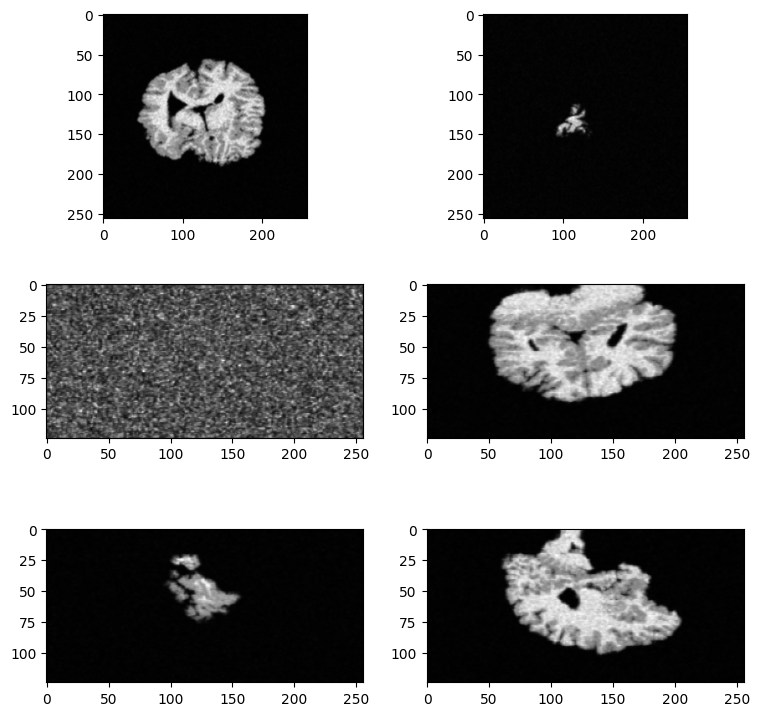

In [5]:
for batch in datamodule.val_dataloader():
    # plot images from batches

    fig, ax = plt.subplots(3, 2, figsize=(9, 9))
    slc = 50
    batch = batch[0]
    img = batch['image']
    target = batch['target']
    ax[0, 0].imshow(img[0, 0, slc, :, :], cmap='gray')
    ax[0, 1].imshow(img[0, 0, slc+50, :, :], cmap='gray')
    ax[1, 0].imshow(img[0, 0, :, slc, :], cmap='gray')
    ax[1, 1].imshow(img[0, 0, :, slc+50, :], cmap='gray')
    ax[2, 0].imshow(img[0, 0, :, :, slc,], cmap='gray')
    ax[2, 1].imshow(img[0, 0, :, :, slc+50,], cmap='gray')
    plt.show()
    break

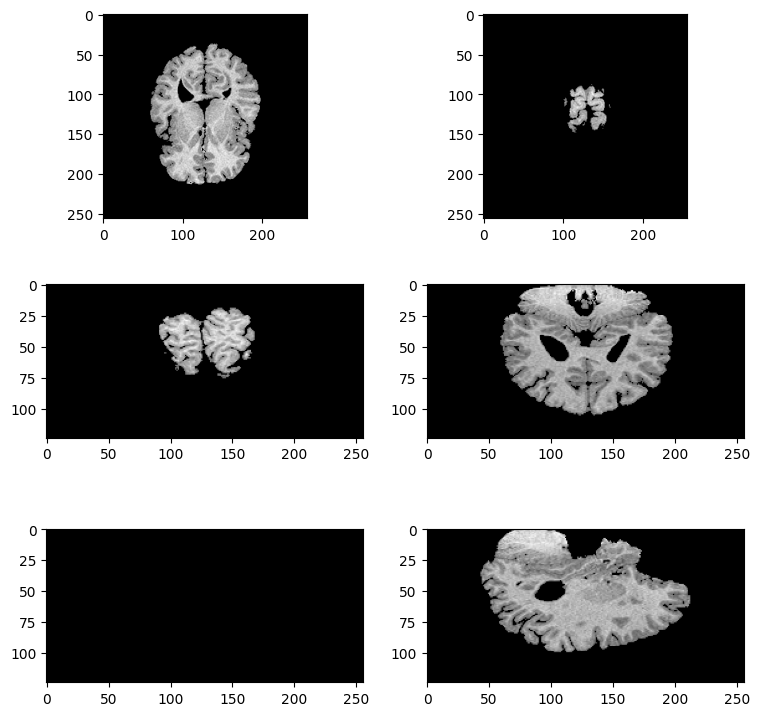

In [7]:
for batch in datamodule.val_dataloader():
    # plot images from batches
    fig, ax = plt.subplots(3, 2, figsize=(9, 9))
    slc = 50
    batch = batch[1]
    img = batch['image']
    target = batch['target']
    ax[0, 0].imshow(img[0, 0, slc, :, :], cmap='gray')
    ax[0, 1].imshow(img[0, 0, slc+50, :, :], cmap='gray')
    ax[1, 0].imshow(img[0, 0, :, slc, :], cmap='gray')
    ax[1, 1].imshow(img[0, 0, :, slc+50, :], cmap='gray')
    ax[2, 0].imshow(img[0, 0, :, :, slc,], cmap='gray')
    ax[2, 1].imshow(img[0, 0, :, :, slc+50,], cmap='gray')
    plt.show()
    break

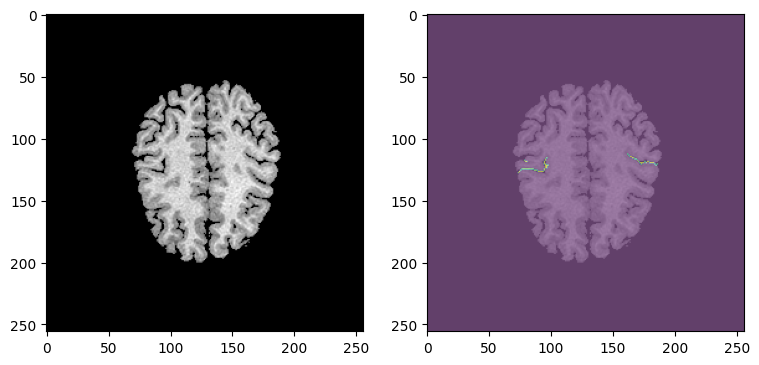

In [300]:
for batch in datamodule.orig_val_dataloader():
    # plot images from batches
    fig, ax = plt.subplots(1, 2, figsize=(9, 9))
    slc = 80
    img = batch['image']
    target = batch['target']
    ax[0].imshow(img[0, 0, slc, :, :], cmap='gray')
    ax[1].imshow(img[0, 0, slc, :, :], cmap='gray', alpha=0.5)
    ax[1].imshow(target[0, slc, :, :], alpha=0.5)    
    break

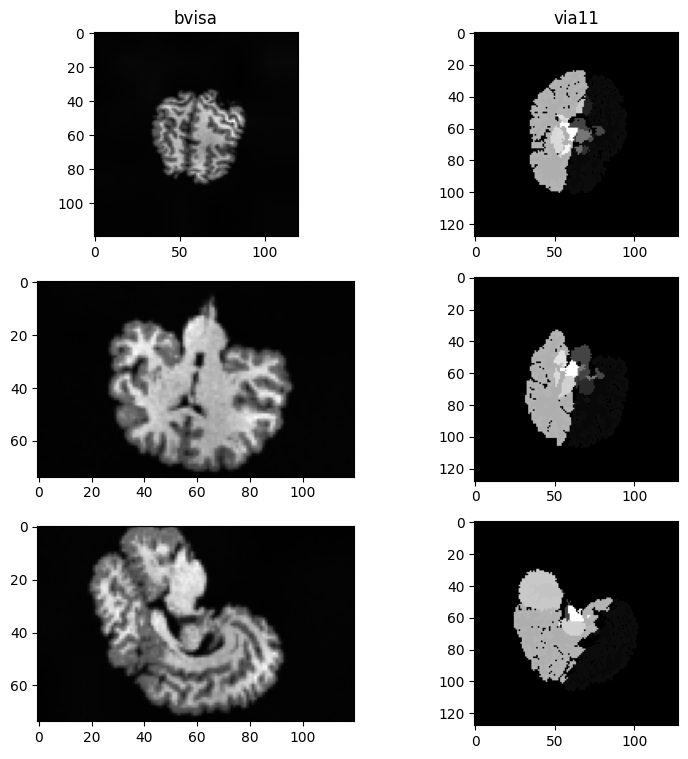

In [35]:
via11_img = sitk.ReadImage('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/synth_generated2x/sub-via023/labels_t1_2.nii.gz')
bvisa_img = sitk.ReadImage('/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa_augm_2x2x2/nobackup/generated/ammon/image_t1_1.nii.gz')

via11_img = sitk.DICOMOrient(via11_img, 'LAS')

bvisa_img = sitk.GetArrayFromImage(bvisa_img)
via11_img = sitk.GetArrayFromImage(via11_img)

sl= 60
fig, axs = plt.subplots(3, 2, figsize=(9, 9))
axs[0, 0].set_title('bvisa')
axs[0, 1].set_title('via11')
axs[0, 0].imshow(bvisa_img[sl, :, :], cmap='gray')
axs[0, 1].imshow(via11_img[sl, :, :], cmap='gray', )
axs[1, 0].imshow(bvisa_img[:, sl, :], cmap='gray')
axs[1, 1].imshow(via11_img[:, sl, :], cmap='gray')
axs[2, 0].imshow(bvisa_img[:, :, sl,], cmap='gray')
axs[2, 1].imshow(via11_img[:, :, sl,], cmap='gray')
plt.show()

In [36]:
np.sum(via11_img==3)

39676